# Proyek Klasifikasi Gambar: Selada

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import random
from random import sample
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import shutil

# Image processing
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from skimage.transform import resize
from skimage.util import random_noise
from skimage.exposure import adjust_gamma

# Deep learning
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D,
    MaxPooling2D, MaxPool2D, Dense, Flatten,
    Dropout, BatchNormalization
)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import tensorflow.keras.preprocessing.image as keras_image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Warning
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [4]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khansartz","key":"45499645474f1473e896fe62629d1776"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d ashishjstar/lettuce-diseases
!unzip lettuce-diseases.zip

Dataset URL: https://www.kaggle.com/datasets/ashishjstar/lettuce-diseases
License(s): apache-2.0
100% 1.25G/1.25G [00:06<00:00, 241MB/s]
100% 1.25G/1.25G [00:06<00:00, 219MB/s]
Archive:  lettuce-diseases.zip
  inflating: Lettuce_disease_datasets/Bacterial/bct (1).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (10).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (11).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (12).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (13).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (14).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (15).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (16).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (17).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (18).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (19).jpg  
  inflating: Lettuce_disease_datasets/Bacterial/bct (2).jpg  
  inflating: Lettuce_disease_datasets/

### Data Preprocessing

Jumlah Gambar per Kelas:
- Healthy: 1123 gambar
- Downy_mildew_on_lettuce: 30 gambar
- Septoria_blight_on_lettuce: 19 gambar
- Viral: 15 gambar

Total Semua Kelas: 1187 gambar

Ukuran rata-rata gambar (dari 1 contoh per kelas): 1112x775


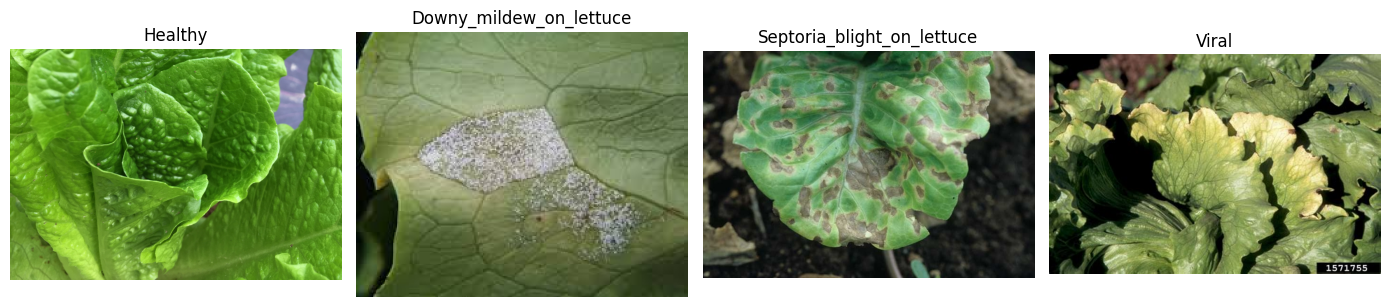

In [7]:
# Path ke folder dataset
dataset_path = "Lettuce_disease_datasets"

# Kelas yang akan digunakan
selected_classes = ['Healthy', 'Downy_mildew_on_lettuce', 'Septoria_blight_on_lettuce', 'Viral']

image_counts = {}
image_shapes = []
example_images = {}

# Loop per kelas
for cls in selected_classes:
    class_path = os.path.join(dataset_path, cls)
    image_list = os.listdir(class_path)

    # Simpan jumlah gambar per kelas
    image_counts[cls] = len(image_list)

    # Ambil 1 gambar contoh untuk disimpan
    sample_path = os.path.join(class_path, image_list[0])
    img = Image.open(sample_path)
    example_images[cls] = img
    image_shapes.append(img.size)

# Print jumlah gambar per kelas dan total
print("Jumlah Gambar per Kelas:")
total_images = 0

for cls, count in image_counts.items():
    print(f"- {cls}: {count} gambar")
    total_images += count

# Print total gambar
print(f"\nTotal Semua Kelas: {total_images} gambar")

# Cek dimensi rata-rata
widths, heights = zip(*image_shapes)
avg_width = sum(widths) // len(widths)
avg_height = sum(heights) // len(heights)
print(f"\nUkuran rata-rata gambar (dari 1 contoh per kelas): {avg_width}x{avg_height}")

# Menampilkan contoh gambar dari tiap kelas
plt.figure(figsize=(len(selected_classes) * 3.5, 5))
for i, cls in enumerate(selected_classes):
    plt.subplot(1, len(selected_classes), i + 1)
    plt.imshow(example_images[cls])
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

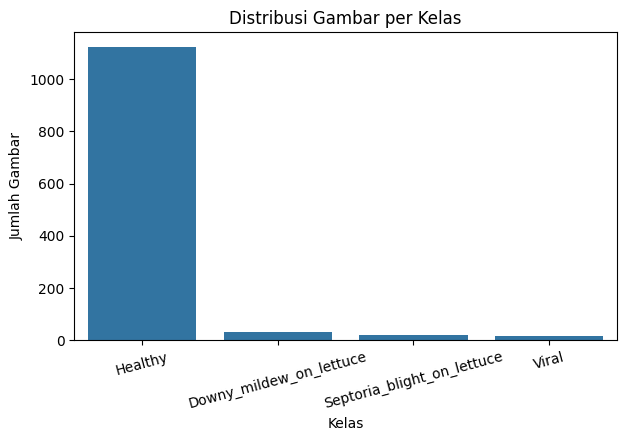

In [8]:
import seaborn as sns

plt.figure(figsize=(7,4))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.xticks(rotation=15)
plt.title("Distribusi Gambar per Kelas")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Kelas")
plt.show()

In [9]:
import shutil

# Buat folder baru buat simpan hanya kelas yang dipilih
new_dataset_path = "Selected_Lettuce_Dataset"
os.makedirs(new_dataset_path, exist_ok=True)

print("\n🚚 Menyalin gambar ke folder baru...")

for cls in selected_classes:
    original_class_path = os.path.join(dataset_path, cls)
    new_class_path = os.path.join(new_dataset_path, cls)
    os.makedirs(new_class_path, exist_ok=True)

    # Ambil semua file gambar dari kelas ini
    for file_name in os.listdir(original_class_path):
        if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            src = os.path.join(original_class_path, file_name)
            dst = os.path.join(new_class_path, file_name)
            shutil.copy(src, dst)

    print(f"✅ {cls} selesai disalin ke {new_class_path}")



🚚 Menyalin gambar ke folder baru...
✅ Healthy selesai disalin ke Selected_Lettuce_Dataset/Healthy
✅ Downy_mildew_on_lettuce selesai disalin ke Selected_Lettuce_Dataset/Downy_mildew_on_lettuce
✅ Septoria_blight_on_lettuce selesai disalin ke Selected_Lettuce_Dataset/Septoria_blight_on_lettuce
✅ Viral selesai disalin ke Selected_Lettuce_Dataset/Viral


#### Augmentasi data


In [10]:
import os
import random
import numpy as np
import cv2
from skimage import io, img_as_ubyte
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fungsi augmentasi
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 3))
    return img

def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 3))
    return img

def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    return tf.image.flip_up_down(img)

def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    return tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))

def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    return tf.image.stateless_random_jpeg_quality(img, (30, 90), seed=[random.randint(0, 100), random.randint(0, 100)])

def sheared(img):
    datagen = ImageDataGenerator(shear_range=0.2)
    img = tf.image.resize(img, (224, 224))
    img = next(iter(datagen.flow(tf.expand_dims(img.numpy(), 0))))[0]
    return img

def warp_shift(img):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = tf.image.resize(img, (224, 224))
    img = next(iter(datagen.flow(tf.expand_dims(img.numpy(), 0))))[0]
    return img

In [11]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# List kelas minor yang mau di-augmentasi dan target jumlah gambar augmentasi
minor_classes = {
    'Viral': 900,
    'Septoria_blight_on_lettuce': 900,
    'Downy_mildew_on_lettuce': 900
}

base_path = "Selected_Lettuce_Dataset"

for class_name, images_to_generate in minor_classes.items():
    print(f"\n⚙️ Proses augmentasi: {class_name}")

    class_path = os.path.join(base_path, class_name)
    os.makedirs(class_path, exist_ok=True)

    images = [
        os.path.join(class_path, im)
        for im in os.listdir(class_path)
        if im.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    i = 1
    while i <= images_to_generate:
        image_path = random.choice(images)
        try:
            original_image = io.imread(image_path)

            # Cek validitas gambar
            if original_image.ndim not in [3, 4]:
                raise ValueError('Invalid image dimensions')

            img_tensor = tf.convert_to_tensor(original_image, dtype=tf.float32) / 255.0

            # Terapkan transformasi random
            n = 0
            transformation_count = random.randint(1, len(transformations))
            transformed_image = img_tensor

            while n <= transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)
                n += 1

            # Convert dan simpan
            transformed_image = transformed_image.numpy() if isinstance(transformed_image, tf.Tensor) else transformed_image
            transformed_image = np.clip(transformed_image * 255, 0, 255).astype(np.uint8)
            transformed_image = img_as_ubyte(transformed_image)

            save_path = os.path.join(class_path, f"augmented_image_{i}.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
            i += 1

        except Exception as e:
            print(f"Gagal proses {image_path} karena: {e}")



⚙️ Proses augmentasi: Viral
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (5).jpg karena: Missing required positional argument
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (14).jpg karena: Missing required positional argument
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (12).jpg karena: Missing required positional argument
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (14).jpg karena: Missing required positional argument
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (13).jpg karena: Missing required positional argument
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (4).jpg karena: Missing required positional argument
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (13).jpg karena: Missing required positional argument
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (9).jpg karena: Missing required positional argument
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (5).jpg karena: Missing required positional argument
Gagal proses Selected_Lettuce_Dataset/Viral/vrl (9).jpg k

#### Data Splitting


label
Healthy                       1123
Downy_mildew_on_lettuce        930
Septoria_blight_on_lettuce     919
Viral                          915
Name: count, dtype: int64


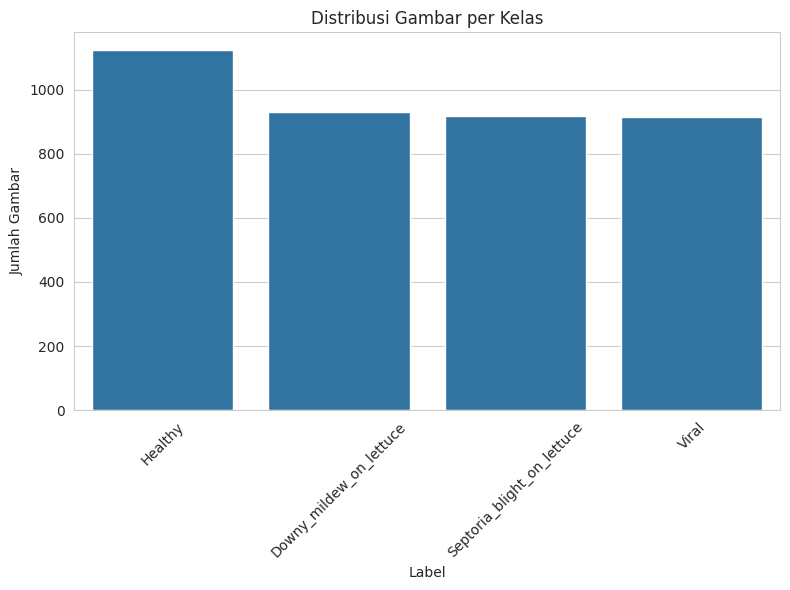

In [12]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ganti sesuai path dataset lo
dataset_path = "Selected_Lettuce_Dataset"

image_paths = []
labels = []

# Loop semua folder dan gambar di dalamnya
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))  # nama folder = label

# Masukin ke DataFrame
df = pd.DataFrame({
    'path': image_paths,
    'label': labels
})

print(df['label'].value_counts())


# Visualisasi distribusi
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Distribusi Gambar per Kelas")
plt.xticks(rotation=45)
plt.xlabel("Label")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

In [13]:
import os
import shutil
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Path awal dan target
raw_path = "Selected_Lettuce_Dataset"
resized_path = "Resized_Lettuce_Dataset"
output_path = "Dataset-Split"
target_size = (224, 224)
selected_classes = ['Healthy', 'Downy_mildew_on_lettuce', 'Septoria_blight_on_lettuce', 'Viral']

# Step 1: Resize dan bersihin data (save ke folder baru)
os.makedirs(resized_path, exist_ok=True)

for cls in selected_classes:
    src_folder = os.path.join(raw_path, cls)
    dst_folder = os.path.join(resized_path, cls)
    os.makedirs(dst_folder, exist_ok=True)

    for fname in tqdm(os.listdir(src_folder), desc=f"Resize {cls}"):
        src_file = os.path.join(src_folder, fname)
        try:
            with Image.open(src_file) as img:
                img = img.convert("RGB")
                img = img.resize(target_size)
                img.save(os.path.join(dst_folder, fname))
        except Exception as e:
            print(f"⚠️ Gagal resize {fname} di {cls}: {e}")

Resize Viral: 100%|██████████| 915/915 [00:00<00:00, 933.19it/s]


In [14]:
# Step 2: Buat dataframe dari image paths
image_paths, labels = [], []

for cls in selected_classes:
    class_path = os.path.join(resized_path, cls)
    for fname in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, fname))
        labels.append(cls)

df = pd.DataFrame({'path': image_paths, 'label': labels})

# Step 3: Split stratified 60:20:20
X_temp, X_test, y_temp, y_test = train_test_split(
    df['path'], df['label'], test_size=0.20, stratify=df['label'], random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

df_train = pd.DataFrame({'path': X_train, 'label': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'label': y_val, 'set': 'val'})
df_test = pd.DataFrame({'path': X_test, 'label': y_test, 'set': 'test'})
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Step 4: Copy file ke folder split
for _, row in tqdm(df_all.iterrows(), total=len(df_all), desc="Copy dataset split"):
    dest_dir = os.path.join(output_path, row['set'], row['label'])
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy2(row['path'], os.path.join(dest_dir, os.path.basename(row['path'])))

# Step 5: Cek distribusi akhir
print("\n📊 Distribusi data hasil split:")
print(df_all.groupby(['set', 'label']).size())

Copy dataset split: 100%|██████████| 3887/3887 [00:00<00:00, 4431.79it/s]


📊 Distribusi data hasil split:
set    label                     
test   Downy_mildew_on_lettuce       186
       Healthy                       225
       Septoria_blight_on_lettuce    184
       Viral                         183
train  Downy_mildew_on_lettuce       558
       Healthy                       673
       Septoria_blight_on_lettuce    551
       Viral                         549
val    Downy_mildew_on_lettuce       186
       Healthy                       225
       Septoria_blight_on_lettuce    184
       Viral                         183
dtype: int64


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4

train_dir = "/content/Dataset-Split/train"
val_dir = "/content/Dataset-Split/val"
test_dir = "/content/Dataset-Split/test"

# ImageDataGenerator buat training (bisa nambahin augmentasi opsional)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2331 images belonging to 4 classes.
Found 778 images belonging to 4 classes.
Found 778 images belonging to 4 classes.


## Modelling

#### Load base model MobileNetV2

In [16]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00


### function build_model(hp) buat Random Search

In [17]:
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape = IMG_SIZE + (3,),
        include_top = False,
        weights     = 'imagenet'
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1))(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer = Adam(hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3])),
        loss      = 'categorical_crossentropy',
        metrics   = ['accuracy']
    )

    return model

#### random search

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [19]:
from keras_tuner import RandomSearch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from functools import reduce

def build_model(hp):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    def apply_layers(x):
        layers = [
            GlobalAveragePooling2D(),
            Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)),
            Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'),
            Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)),
            Dense(NUM_CLASSES, activation='softmax')
        ]
        return reduce(lambda acc, layer: layer(acc), layers, x)

    output = apply_layers(base_model.output)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-4, 5e-4, 1e-3])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search_dir',
    project_name='mobilenetv2_tuning'
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

tuner.search(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Trial 10 Complete [00h 07m 47s]
val_accuracy: 0.9361979365348816

Best val_accuracy So Far: 0.9583333134651184
Total elapsed time: 01h 12m 17s


In [21]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evaluasi dan Visualisasi

In [22]:
# Evaluasi pada masing-masing set
train_loss, train_acc = best_model.evaluate(train_generator, verbose=1)
val_loss, val_acc = best_model.evaluate(val_generator, verbose=1)
test_loss, test_acc = best_model.evaluate(test_generator, verbose=1)

print(f"Akurasi Train Set: {train_acc*100:.2f}%")
print(f"Akurasi Validation Set: {val_acc*100:.2f}%")
print(f"Akurasi Test Set: {test_acc*100:.2f}%")

73/73 ━━━━━━━━━━━━━━━━━━━━ 33s 393ms/step - accuracy: 0.9671 - loss: 0.0914
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.9570 - loss: 0.1420
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9482 - loss: 0.1720
Akurasi Train Set: 96.95%
Akurasi Validation Set: 95.76%
Akurasi Test Set: 94.99%


In [23]:
# Fine-tune model terbaik supaya dapet history
best_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 473ms/step - accuracy: 0.9590 - loss: 0.1143 - val_accuracy: 0.9653 - val_loss: 0.1085 - learning_rate: 1.0000e-04
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9575 - loss: 0.1038 - val_accuracy: 0.9627 - val_loss: 0.1078 - learning_rate: 1.0000e-04
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 371ms/step - accuracy: 0.9413 - loss: 0.1236 - val_accuracy: 0.9576 - val_loss: 0.1065 - learning_rate: 1.0000e-04
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 385ms/step - accuracy: 0.9492 - loss: 0.1219 - val_accuracy: 0.9563 - val_loss: 0.1042 - learning_rate: 1.0000e-04
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 373ms/step - accuracy: 0.9603 - loss: 0.0952 - val_accuracy: 0.9563 - val_loss: 0.1047 - learning_rate: 1.0000e-04
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 378ms/step - accuracy: 0.9612 - loss: 0.1046 - val_accuracy: 0.9537 - val_loss: 0.1068 - learning_rate: 1.0000e-04
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 369ms/step - acc

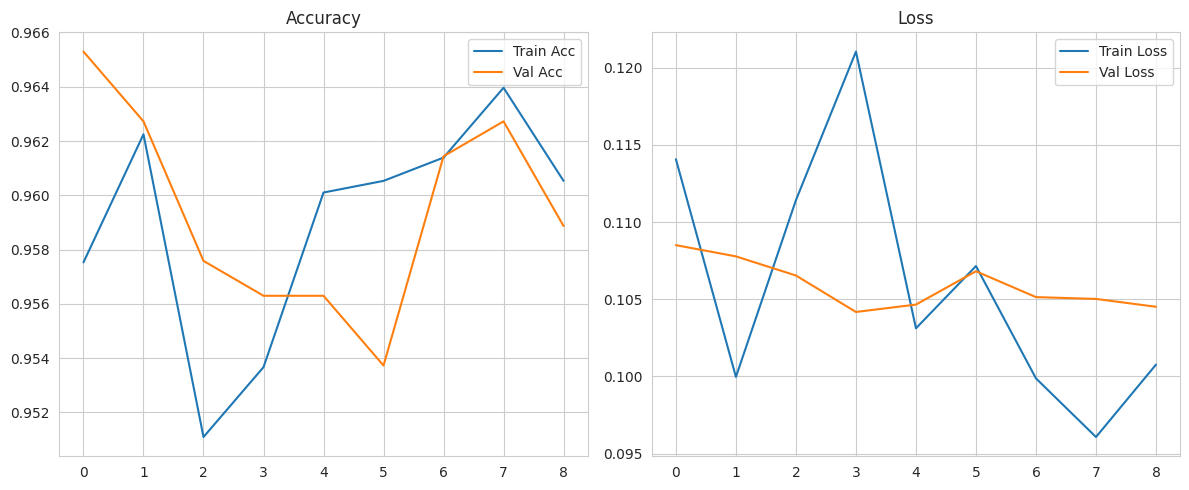

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step


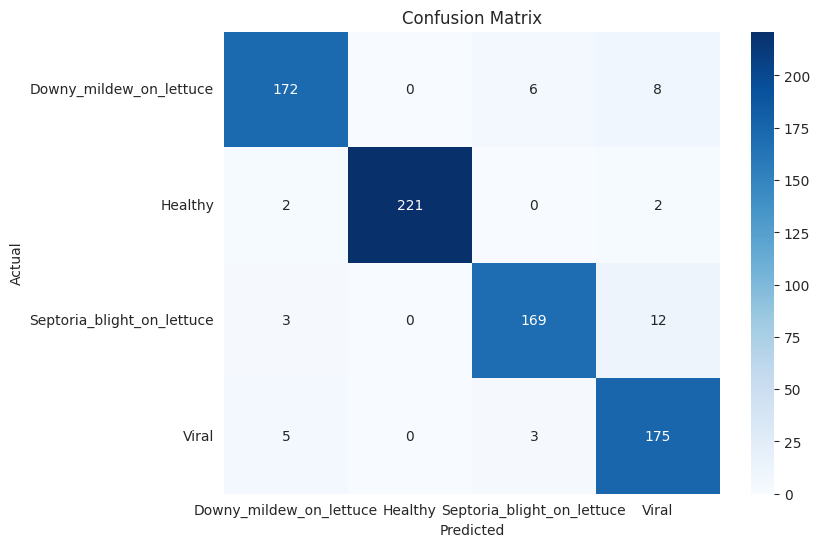

                            precision    recall  f1-score   support

   Downy_mildew_on_lettuce     0.9451    0.9247    0.9348       186
                   Healthy     1.0000    0.9822    0.9910       225
Septoria_blight_on_lettuce     0.9494    0.9185    0.9337       184
                     Viral     0.8883    0.9563    0.9211       183

                  accuracy                         0.9473       778
                 macro avg     0.9457    0.9454    0.9451       778
              weighted avg     0.9486    0.9473    0.9476       778



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_generator.reset()
preds = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

## Konversi Model

In [26]:
import os
import tensorflowjs as tfjs

# SavedModel
tf.saved_model.save(best_model, 'saved_model')

# TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpen label.txt
with open('tflite/label.txt', 'w') as f:
    for label in class_labels:
        f.write(label + '\n')

# TensorFlow.js
tfjs.converters.save_keras_model(best_model, 'tfjs_model')

Saved artifact at '/tmp/tmpebid98ge'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135640441319120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135640441320656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135640441314896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135640441312976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135640441308176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135640441318352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135640441317200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135640441322192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135640441321808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135640441310480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13564044130856

failed to lookup keras version from the file,
    this is likely a weight only file


In [27]:
# Simpan ke h5

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('lettuce_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
from google.colab import files
files.download('lettuce_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import shutil

In [31]:
shutil.make_archive('Dataset-Split', 'zip', 'Dataset-Split')

'/content/Dataset-Split.zip'

In [32]:
from google.colab import files
files.download('Dataset-Split.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
shutil.make_archive('tflite', 'zip', 'tflite')

'/content/tflite.zip'

In [34]:
from google.colab import files
files.download('tflite.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
shutil.make_archive('saved_model', 'zip', 'saved_model')

'/content/saved_model.zip'

In [36]:
from google.colab import files
files.download('saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>